In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import os
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Set seaborn theme
sns.set_theme()


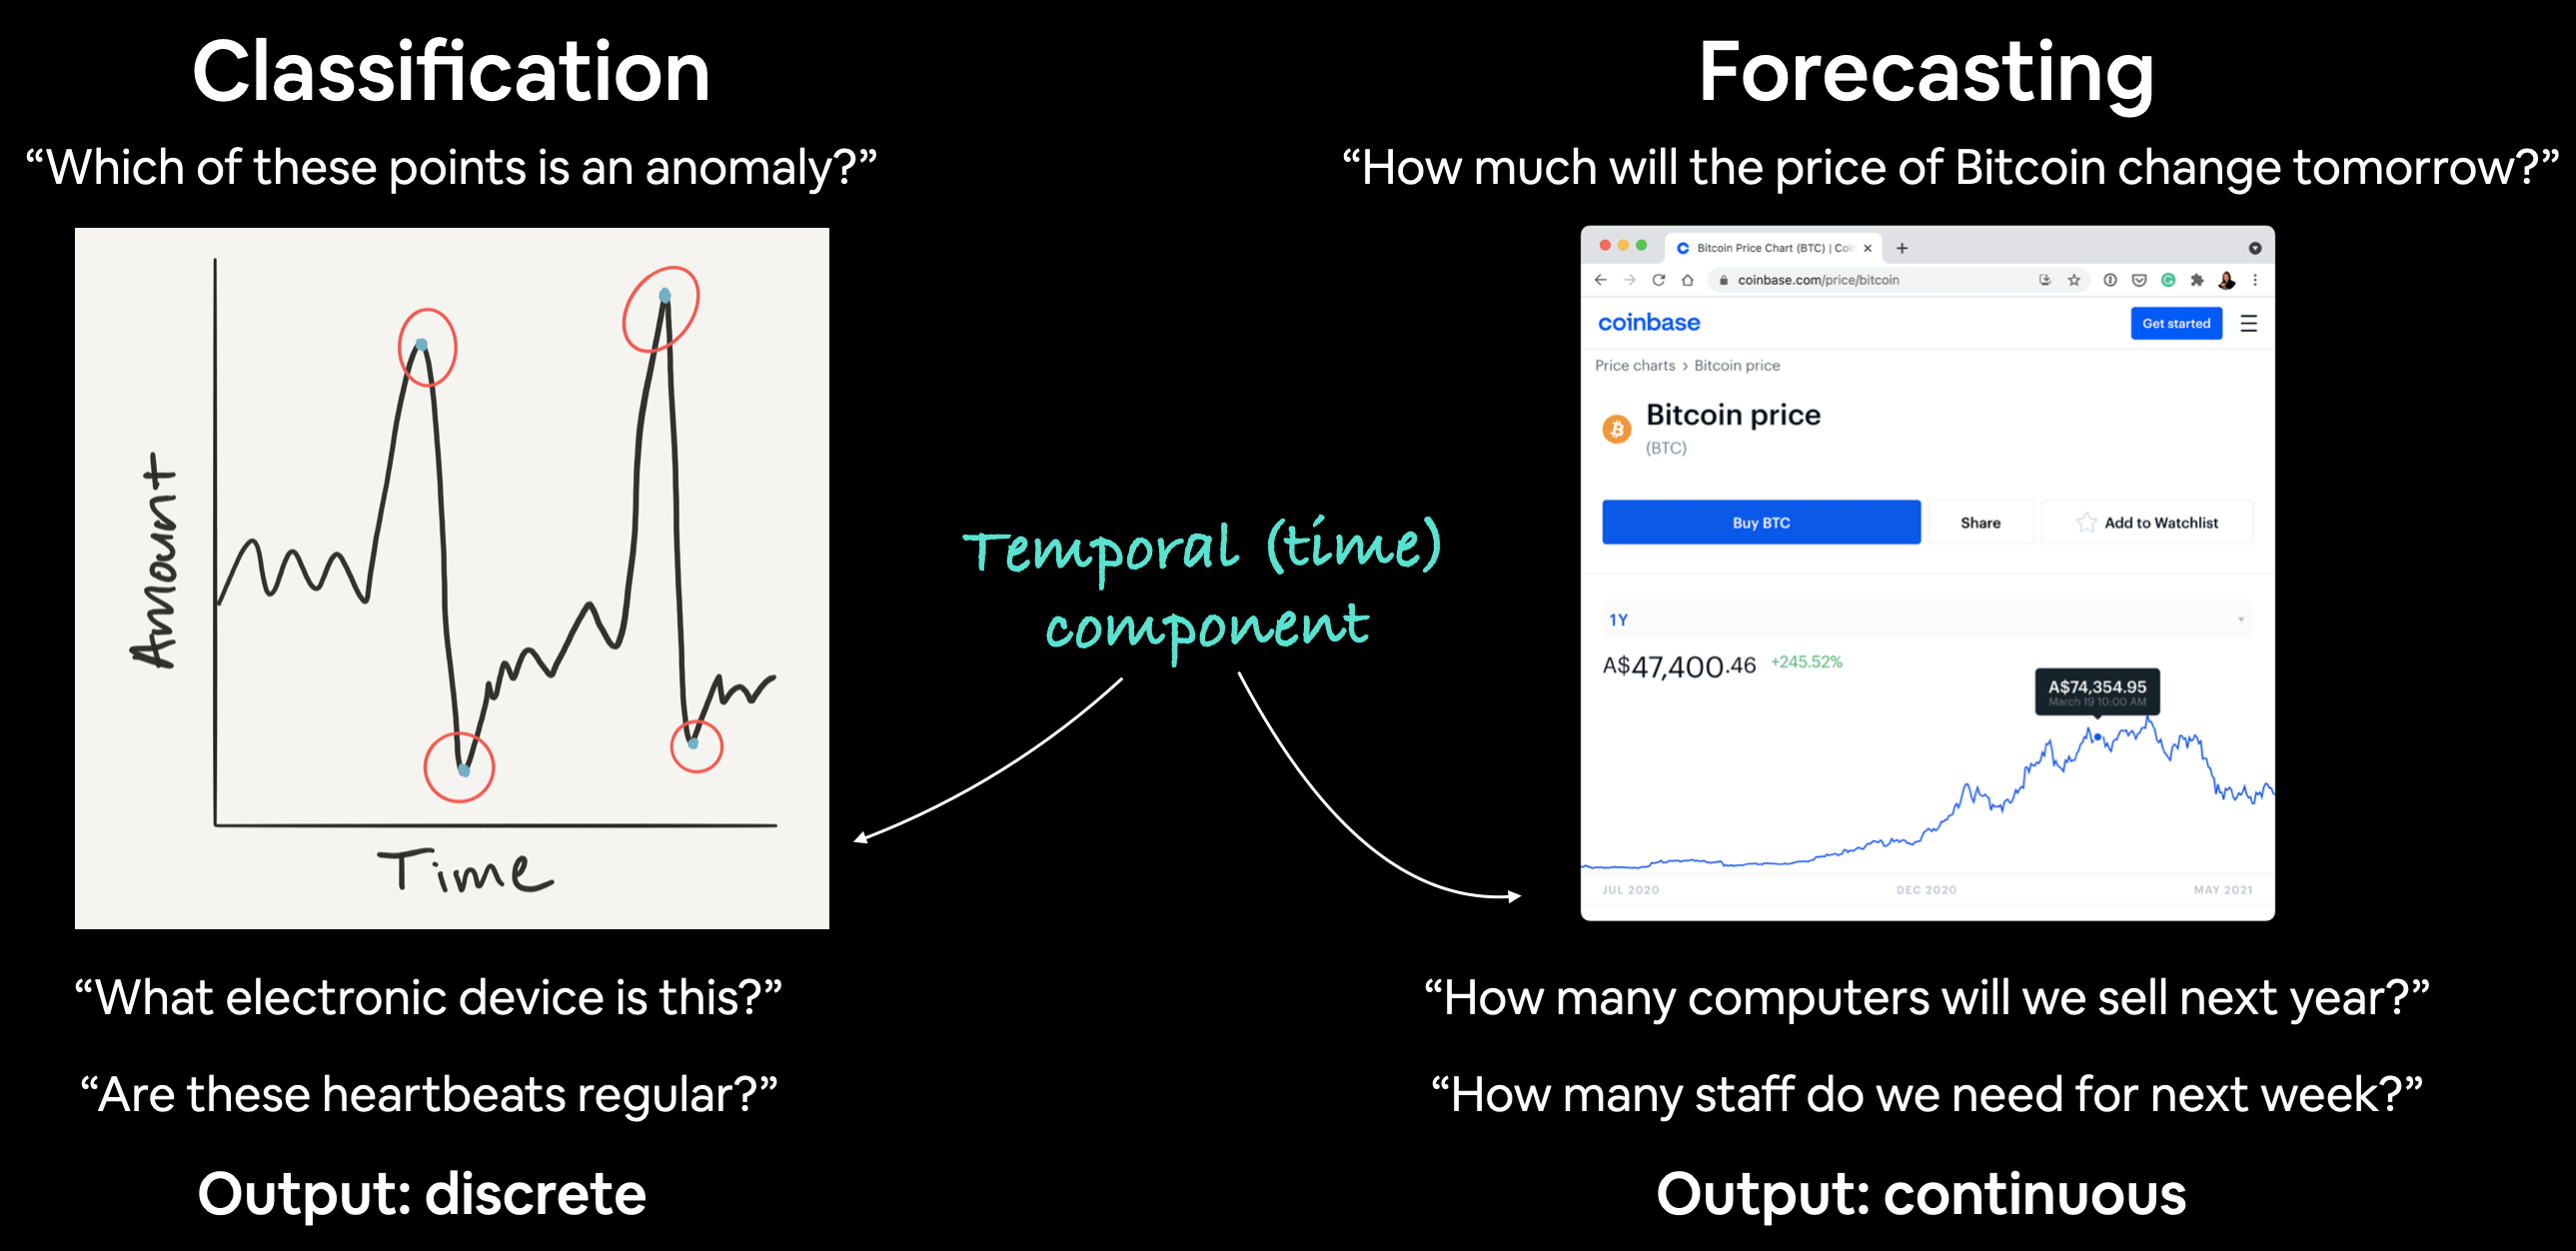

In [3]:
def evaluate_preds(y_true, y_pred):
    # Ensure inputs are tensors
    y_true = tf.convert_to_tensor(y_true)
    y_pred = tf.convert_to_tensor(y_pred)

    # MAE
    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mae_metric.update_state(y_true, y_pred)
    mae = mae_metric.result().numpy()

    # MSE
    mse_metric = tf.keras.metrics.MeanSquaredError()
    mse_metric.update_state(y_true, y_pred)
    mse = mse_metric.result().numpy()

    # RMSE
    rmse = tf.sqrt(mse).numpy()

    # MAPE
    mape_metric = tf.keras.metrics.MeanAbsolutePercentageError()
    mape_metric.update_state(y_true, y_pred)
    mape = mape_metric.result().numpy()

    # Handle inf/nan in MAPE
    if tf.math.is_nan(mape) or tf.math.is_inf(mape):
        mape = 0.0

    return {
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
        "mape": mape
    }


In [4]:
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=5)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3] -> Label: [4 5 6 7 8]


In [5]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [6]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels



In [7]:
def create_model_checkpoint(model_name, save_path='D:\\data science projects\\project 2 unfinished'):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_path, model_name + ".keras"),
        verbose=1,
        save_best_only=True
    )

In [8]:
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is NOT stationary.")


In [117]:
def actual_30_days():
    actualData=pd.read_csv(r"D:\data science projects\project 2 unfinished\bitcoin_ohlc.csv")
    actualData['Date']=pd.to_datetime(actualData['Date'])
    actualData.set_index('Date', inplace=True)
    actualData = actualData.resample('D').last().dropna()
    actualData=actualData[2:]['Price']
    return actualData

In [10]:
def plot_actual_forecast(forecast,actualData):
    plt.figure(figsize=(20, 5))
    plt.plot(forecast.index, forecast.values, label='Day Forecast')
    plt.plot(actualData.index,actualData.values,label='Actual data')
    plt.xlabel('Days Ahead')
    plt.ylabel('Predicted Price')
    plt.title('Bitcoin Price Forecast for Next 30 Days')
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
!nvidia-smi -L


GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU (UUID: GPU-7748df00-6c0b-ff6e-fc8d-cc52951076f5)


In [12]:
def wrangle(path):
    data=pd.read_csv(path,parse_dates=['datetime'])
    data.dropna(inplace=True)
    data['datetime']=pd.to_datetime(data['datetime'])
    data.set_index('datetime',inplace=True)
    data=data.resample('D').last()
    data = data.reset_index()
    data['datetime'] = data['datetime'].dt.strftime('%Y-%#m-%#d')
    data.set_index('datetime',inplace=True)
    data.drop_duplicates(inplace=True)
    data.drop(columns='Timestamp',inplace=True)
    return data

In [13]:
data=wrangle("D:\\data science projects\\project 2 unfinished\\btcusd_1-min_data.csv")

In [14]:
data

,Open,High,Low,Close,Volume
datetime,,,,,
2012-1-1,4.84,4.84,4.84,4.84,0.000000
2012-1-2,5.00,5.00,5.00,5.00,0.000000
2012-1-3,5.29,5.29,5.29,5.29,0.000000
2012-1-4,5.57,5.57,5.57,5.57,0.000000
2012-1-5,6.42,6.42,6.42,6.42,0.000000
...,...,...,...,...,...
2025-3-11,78599.00,78818.00,78576.00,78763.00,24.694112
2025-3-12,83644.00,83644.00,83620.00,83620.00,0.025203
2025-3-13,83677.00,83677.00,83677.00,83677.00,0.000533


In [15]:
#sns.lineplot(x=data.index,y=data['High']-data['Low'])

In [16]:
"""
sns.lineplot(x=data.index,y=data['Open'],label='Open')
sns.lineplot(x=data.index,y=data['Close'],label='Close')
plt.legend()

"""

"\nsns.lineplot(x=data.index,y=data['Open'],label='Open')\nsns.lineplot(x=data.index,y=data['Close'],label='Close')\nplt.legend()\n\n"

In [17]:
"""
# 1. Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# 2. Distribution of Closing Prices
plt.figure(figsize=(10, 4))
sns.histplot(data['Close'], kde=True, bins=50)
plt.title("Distribution of Closing Prices")
plt.xlabel("Close Price")
plt.ylabel("Frequency")
plt.show()

# 3. Moving Average Plot
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()

plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['SMA_20'], label='SMA 20', linestyle='--')
plt.plot(data['SMA_50'], label='SMA 50', linestyle='--')
plt.title("Close Price with Moving Averages")
plt.legend()
plt.show()

# 4. Volatility (Rolling Standard Deviation)
data['Rolling_STD_20'] = data['Close'].rolling(window=20).std()

plt.figure(figsize=(12, 4))
plt.plot(data['Rolling_STD_20'], color='orange')
plt.title("20-Day Rolling Volatility (Standard Deviation)")
plt.ylabel("Std Dev")
plt.show()

# 5. Candlestick Chart
candlestick = go.Figure(data=[go.Candlestick(x=data.index,
                open=data['Open'], high=data['High'],
                low=data['Low'], close=data['Close'])])

candlestick.update_layout(title='Candlestick Chart',
                          xaxis_title='Date', yaxis_title='Price',
                          xaxis_rangeslider_visible=False)
candlestick.show()

"""


'\n# 1. Correlation Heatmap\nplt.figure(figsize=(10, 6))\nsns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")\nplt.title("Correlation Heatmap")\nplt.show()\n\n# 2. Distribution of Closing Prices\nplt.figure(figsize=(10, 4))\nsns.histplot(data[\'Close\'], kde=True, bins=50)\nplt.title("Distribution of Closing Prices")\nplt.xlabel("Close Price")\nplt.ylabel("Frequency")\nplt.show()\n\n# 3. Moving Average Plot\ndata[\'SMA_20\'] = data[\'Close\'].rolling(window=20).mean()\ndata[\'SMA_50\'] = data[\'Close\'].rolling(window=50).mean()\n\nplt.figure(figsize=(14, 6))\nplt.plot(data[\'Close\'], label=\'Close Price\')\nplt.plot(data[\'SMA_20\'], label=\'SMA 20\', linestyle=\'--\')\nplt.plot(data[\'SMA_50\'], label=\'SMA 50\', linestyle=\'--\')\nplt.title("Close Price with Moving Averages")\nplt.legend()\nplt.show()\n\n# 4. Volatility (Rolling Standard Deviation)\ndata[\'Rolling_STD_20\'] = data[\'Close\'].rolling(window=20).std()\n\nplt.figure(figsize=(12, 4))\nplt.plot(data[\'Rolli

In [18]:
data=data.drop(columns=['Open','High','Low','Volume'])
#,'SMA_20','SMA_50','Rolling_STD_20'

In [19]:
data

,Close
datetime,
2012-1-1,4.84
2012-1-2,5.00
2012-1-3,5.29
2012-1-4,5.57
2012-1-5,6.42
...,...
2025-3-11,78763.00
2025-3-12,83620.00
2025-3-13,83677.00


In [20]:
thershold_train=int(len(data)*0.7)
train_data=data[:thershold_train]
test_data=data[thershold_train:]
print(f'the length of train data is = {train_data.shape}')
print(f'the length of test data is = {test_data.shape}')
"""
sns.lineplot(train_data['Close'],label='train')
sns.lineplot(val_data['Close'],label='val')
sns.lineplot(test_data['Close'],label='test')
"""


y_train=train_data['Close'].to_numpy()
y_test=test_data['Close'].to_numpy()

x_train=train_data.index.to_numpy()
x_test=test_data.index.to_numpy()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

the length of train data is = (3376, 1)
the length of test data is = (1447, 1)


((3376,), (1447,), (3376,), (1447,))

In [ ]:
period_date = pd.date_range(start=list(x_test)[-1], periods=42, freq='1d').tolist()
period_date = pd.to_datetime(period_date)

In [21]:
naive_forecast=y_test[:-1]
naive_forecast

array([59118.91, 58582.36, 58899.97, ..., 83620.  , 83677.  , 83975.  ])

In [22]:
"""
sns.lineplot(train_data['Open'],label='train')
sns.lineplot(val_data['Open'],label='val')
sns.lineplot(test_data['Open'],label='test')
sns.lineplot(y=naive_forecast,x=x_test[1:],label='naive')
"""

"\nsns.lineplot(train_data['Open'],label='train')\nsns.lineplot(val_data['Open'],label='val')\nsns.lineplot(test_data['Open'],label='test')\nsns.lineplot(y=naive_forecast,x=x_test[1:],label='naive')\n"

In [23]:
naive_results=evaluate_preds(y_true=y_test[1:],y_pred=naive_forecast)
naive_results

{'mae': 926.60516, 'mse': 2241694.8, 'rmse': 1497.229, 'mape': 2.0893135}

In [24]:
##############################################################      DENSE NN     ###################################################################

In [25]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 5 # use a week worth of timesteps to predict the horizon

In [26]:
full_windows, full_labels = make_windows(data['Close'].values, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)
train_Window , test_window,train_label,test_label=make_train_test_splits(full_windows,full_labels)
print(f'train_Window:{train_Window.shape},test_window:{test_window.shape},train_label:{train_label.shape},test_label:{test_label.shape}')

train_Window:(3854, 5),test_window:(964, 5),train_label:(3854, 1),test_label:(964, 1)


In [27]:
model_1=tf.keras.Sequential([
    tf.keras.layers.Dense( 256,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(HORIZON,activation='linear')
],name='model_1_dense')

model_1.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mae']
)

In [28]:
history=model_1.fit(x=train_Window,y=train_label,epochs=100,verbose=1,batch_size=16,validation_data=(test_window, test_label),callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
239/241 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1580.8138 - mae: 1580.8138
Epoch 1: val_loss improved from inf to 2517.57642, saving model to D:\data science projects\project 2 unfinished\model_1_dense.keras
241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1570.2294 - mae: 1570.2294 - val_loss: 2517.5764 - val_mae: 2517.5764
Epoch 2/100
235/241 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 453.7007 - mae: 453.7007
Epoch 2: val_loss did not improve from 2517.57642
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 454.2969 - mae: 454.2969 - val_loss: 2566.6509 - val_mae: 2566.6509
Epoch 3/100
235/241 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 364.2997 - mae: 364.2997
Epoch 3: val_loss did not improve from 2517.57642
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 365.4993 - mae: 365.4993 - val_loss: 2642.3433 - val_mae: 2642.3433
Epoch 4/100
232/241 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 483.5935 - mae: 483.5935
Epoch 4: val_loss improved from 2517.57642 to 1455.53577, saving mod

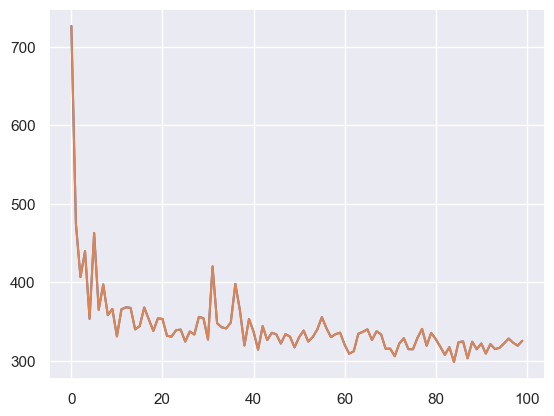

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['mae'])

In [ ]:
model_1 = tf.keras.models.load_model(r"D:\data science projects\project 2 unfinished\model_1_dense.keras")
dense_forecast=model_1.predict(test_window)
forecast=tf.squeeze(dense_forecast)
model_1_prefor=evaluate_preds(y_true=test_label,y_pred=dense_forecast)
model_1_prefor

 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


{'mae': 974.283, 'mse': 2442475.8, 'rmse': 1562.8422, 'mape': 2.0436435}

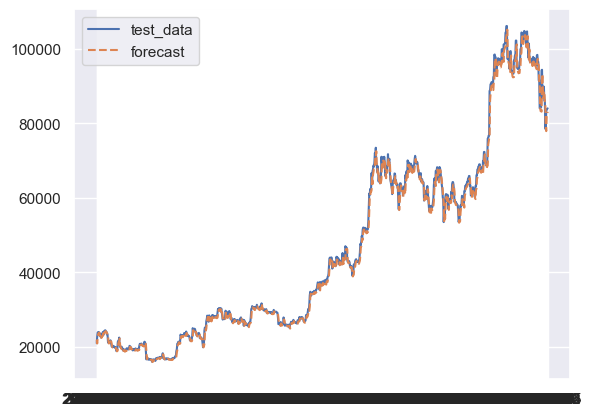

In [31]:
plt.plot(x_test[-len(test_window):],test_label[:,0],label='test_data')
plt.plot(x_test[-len(test_window):],dense_forecast,label='forecast',linestyle="--")
plt.legend()

In [32]:
"""full_windows, full_labels = make_windows(y_test, window_size=WINDOW_SIZE, horizon=HORIZON)

len(full_windows), len(full_labels)"""

'full_windows, full_labels = make_windows(y_test, window_size=WINDOW_SIZE, horizon=HORIZON)\n\nlen(full_windows), len(full_labels)'

In [ ]:


# Start with the last window from your original series
last_window = full_windows[-1]  # shape should be (WINDOW_SIZE,)
forecast_30 = []
current_window = last_window

for _ in range(30):
    pred = model_1.predict(current_window[np.newaxis], verbose=0)
    forecast_30.append(pred[0][0])
    current_window = np.append(current_window[1:], pred[0][0])

forecast_30 = np.array(forecast_30)
model_1_forecast=pd.DataFrame(
    {
        'datetime':period_date,
        'forecast':forecast_30
    }
)

model_1_forecast.set_index('datetime', inplace=True)
model_1_forecast.head()



,forecast
datetime,
2025-03-15,83141.054688
2025-03-16,82604.046875
2025-03-17,81871.140625
2025-03-18,81168.570312
2025-03-19,80431.742188


In [34]:
#actual data
actualData=actual_30_days()

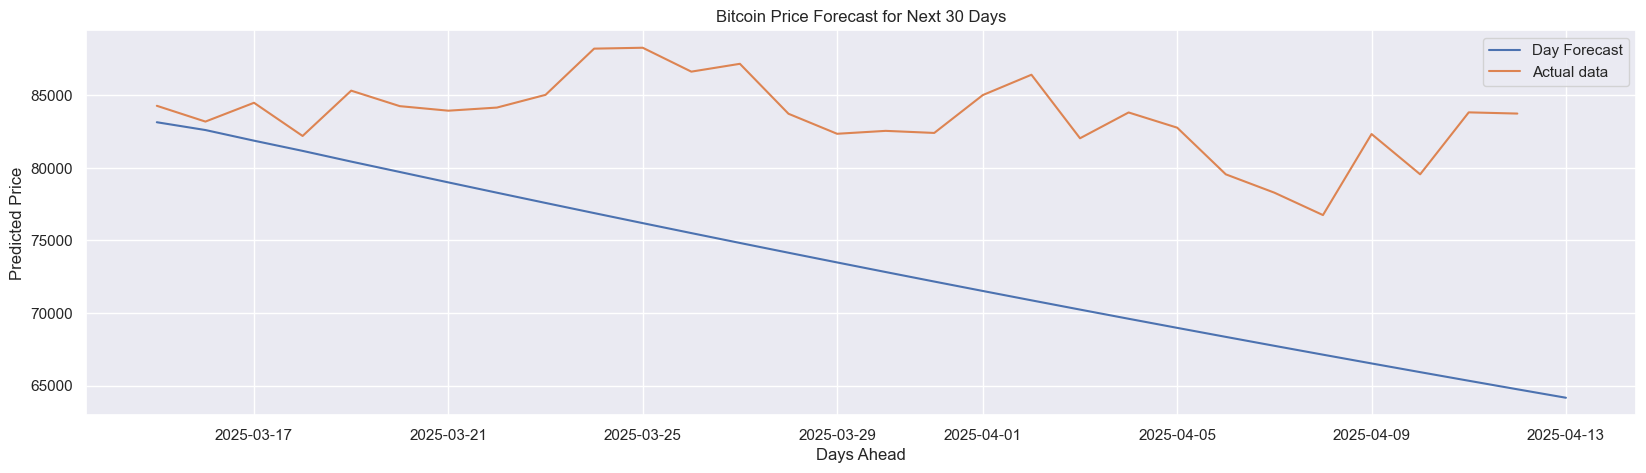

In [35]:
plot_actual_forecast(model_1_forecast,actualData)

In [36]:
model_1_error=evaluate_preds(y_pred=forecast_30[:-1],y_true=actualData.values)
model_1_error

{'mae': 9837.677, 'mse': 120943170.0, 'rmse': 10997.416, 'mape': 11.78961}

In [37]:
##############################################################     LSTM       ###################################################################

In [38]:
# dataa=data['Close'].diff().dropna()

In [39]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 9 # use a week worth of timesteps to predict the horizon

In [40]:
train_Window = train_Window[..., np.newaxis]  # shape becomes (num_samples, 5, 1)
test_window = test_window[..., np.newaxis]

train_Window.shape

(3854, 5, 1)

In [41]:
train_Window.shape

(3854, 5, 1)

In [42]:
full_windows, full_labels = make_windows(data['Close'].values, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)
train_Window , test_window,train_label,test_label=make_train_test_splits(full_windows,full_labels)
print(f'train_Window:{train_Window.shape},test_window:{test_window.shape},train_label:{train_label.shape},test_label:{test_label.shape}')

train_Window:(3851, 9),test_window:(963, 9),train_label:(3851, 1),test_label:(963, 1)


In [43]:
train_Window = train_Window[..., np.newaxis]  # shape becomes (num_samples, 5, 1)
test_window = test_window[..., np.newaxis]

train_Window.shape

(3851, 9, 1)

In [ ]:

model_2=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE,HORIZON)),
    LSTM(1024,activation='relu',return_sequences=True),
    LSTM(512,activation='relu',return_sequences=True),
    LSTM(256,activation='relu',return_sequences=True),
   # LSTM(128,activation='relu',return_sequences=True),
    LSTM(64,activation='relu',return_sequences=True),
    LSTM(32,activation='relu',return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    LSTM(64,activation='relu'),
    tf.keras.layers.Dense(HORIZON,activation='linear')
],name='model_2_lstm')
model_2.compile(loss='mae',optimizer=tf.keras.optimizers.Adam( learning_rate=1e-3),metrics=['mse'])



In [ ]:
# model_2.summary()

Model: "model_2_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 9, 1024)        │     4,202,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 9, 512)         │     3,147,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 9, 256)         │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 9, 64)          │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 9, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,257,217 (31.50 MB)

 Trainable params: 8,257,217 (31.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#best batch_size=64
model_2.fit(train_Window,train_label,verbose=1,epochs=50,batch_size=128,validation_data=(test_window, test_label),callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [47]:
model_2 = tf.keras.models.load_model(r"D:\data science projects\project 2 unfinished\model_2_lstm.keras")
lstm_forecast=model_2.predict(test_window)

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


In [48]:
lstm_forecast

array([[ 22348.932],
       [ 23037.977],
       [ 22897.875],
       [ 22488.621],
       [ 22148.049],
       [ 21995.818],
       [ 21974.39 ],
       [ 21579.156],
       [ 21851.723],
       [ 23083.527],
       [ 23511.633],
       [ 23486.266],
       [ 23337.596],
       [ 23069.848],
       [ 22723.867],
       [ 22740.3  ],
       [ 22787.629],
       [ 22548.66 ],
       [ 22861.965],
       [ 23040.574],
       [ 23158.215],
       [ 23389.594],
       [ 23282.508],
       [ 23686.941],
       [ 23938.389],
       [ 23923.566],
       [ 23901.049],
       [ 23680.154],
       [ 23370.121],
       [ 23024.059],
       [ 22415.506],
       [ 21865.959],
       [ 20988.195],
       [ 20945.94 ],
       [ 21113.8  ],
       [ 21029.695],
       [ 21170.098],
       [ 21015.48 ],
       [ 20607.723],
       [ 20031.941],
       [ 19767.398],
       [ 19765.68 ],
       [ 19793.54 ],
       [ 19748.18 ],
       [ 19755.09 ],
       [ 19585.479],
       [ 19541.324],
       [ 1942

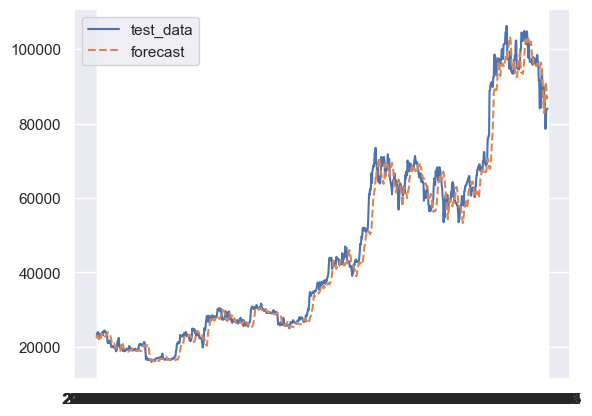

In [49]:
plt.plot(x_test[-len(test_window):],test_label[:,0],label='test_data')
plt.plot(x_test[-len(test_window):],lstm_forecast,label='forecast',linestyle="--")
plt.legend()

In [50]:
model_2_error=evaluate_preds(test_label,lstm_forecast)
model_2_error

{'mae': 2543.1052, 'mse': 14994051.0, 'rmse': 3872.2153, 'mape': 5.3614554}

In [51]:
current_window[...,np.newaxis].shape

(5, 1)

In [139]:
forecast_30 = []
last_window = full_windows[-1] 
current_window = last_window
for _ in range(42):
    pred = model_2.predict(current_window.reshape(1, WINDOW_SIZE, 1), verbose=0)
    forecast_30.append(pred[0][0])  # assuming output shape is (1, 1)
    # Shift window and append new prediction
    current_window = np.append(current_window[1:], pred[0][0])
forecast_30 = np.array(forecast_30)


model_2_forecast=pd.DataFrame(
    {
        'datetime':period_date,
        'forecast':forecast_30
    }
)

model_2_forecast.set_index('datetime',inplace=True)


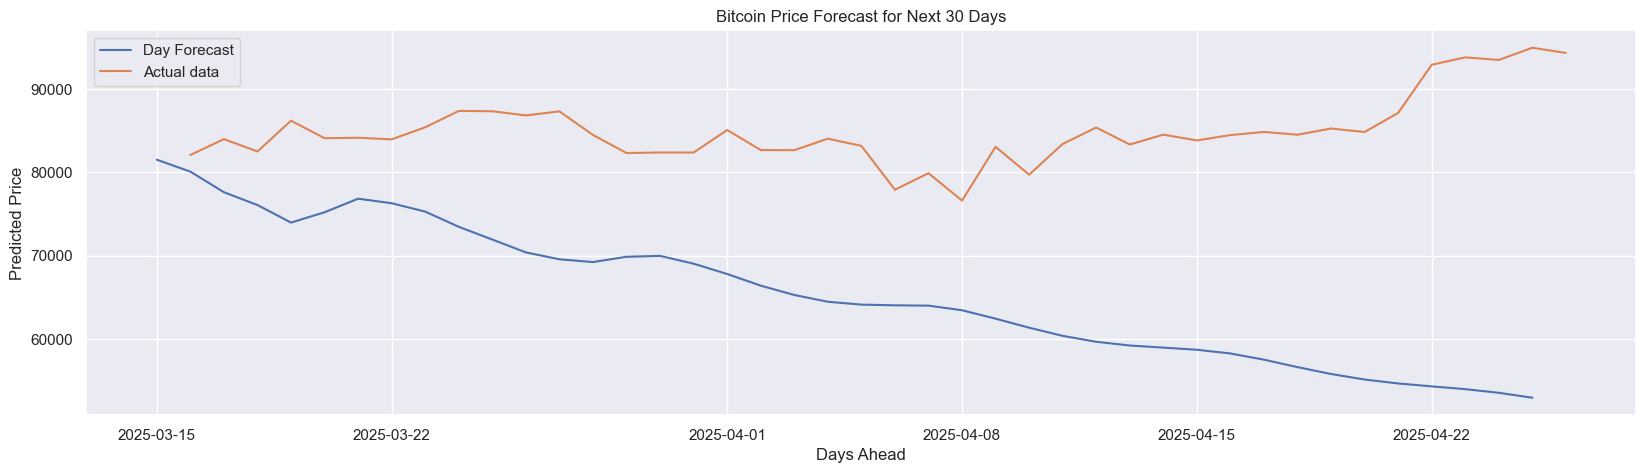

{'mae': 19476.465, 'mse': 485812030.0, 'rmse': 22041.145, 'mape': 22.601456}

In [140]:
plot_actual_forecast(forecast=model_2_forecast,actualData=actualData)
model_2_forecast_error=evaluate_preds(y_pred=model_2_forecast.values,y_true=actualData.values)
model_2_forecast_error


In [ ]:
##############################################################       BiLSTM      ###################################################################

In [63]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE,HORIZON)),
    Bidirectional(LSTM(256,return_sequences=True,activation='relu')),
    Bidirectional(LSTM(128,return_sequences=True,activation='relu')),
    Bidirectional(LSTM(128,return_sequences=True,activation='relu')),      
    Bidirectional(LSTM(64,return_sequences=True,activation='relu')),
    Bidirectional(LSTM(32,return_sequences=False,activation='relu')),
    Dense(HORIZON,activation='linear')
],name='model_3_bilstm')


model_3.compile(loss='mae',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=['mse'])

In [64]:
model_3.summary()

Model: "model_3_bilstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 9, 512)         │       528,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 9, 256)         │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 9, 256)         │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 9, 128)         │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,784,641 (6.81 MB)

 Trainable params: 1,784,641 (6.81 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
model_3.fit(train_Window,train_label,verbose=1,epochs=100,batch_size=64,validation_data=(test_window,test_label),callbacks=(create_model_checkpoint(model_name=model_3.name)))

Epoch 1/100
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 9345.5020 - mse: 319969568.0000
Epoch 1: val_loss improved from inf to 43997.54688, saving model to D:\data science projects\project 2 unfinished\model_3_bilstm.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - loss: 9338.9746 - mse: 319512384.0000 - val_loss: 43997.5469 - val_mse: 2536531456.0000
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 8582.5244 - mse: 271695008.0000
Epoch 2: val_loss improved from 43997.54688 to 40557.83203, saving model to D:\data science projects\project 2 unfinished\model_3_bilstm.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 8582.5566 - mse: 271686080.0000 - val_loss: 40557.8320 - val_mse: 2179772160.0000
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 8122.6274 - mse: 243181920.0000
Epoch 3: val_loss did not improve from 40557.83203
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 8122.0923 - mse: 243179840.0000 - val_loss: 41228.2539 - val_mse: 2236042496.0000
Epoc

In [66]:
model_3 = tf.keras.models.load_model(r"D:\data science projects\project 2 unfinished\model_3_bilstm.keras")
bilstm_forecast=model_3.predict(test_window)

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


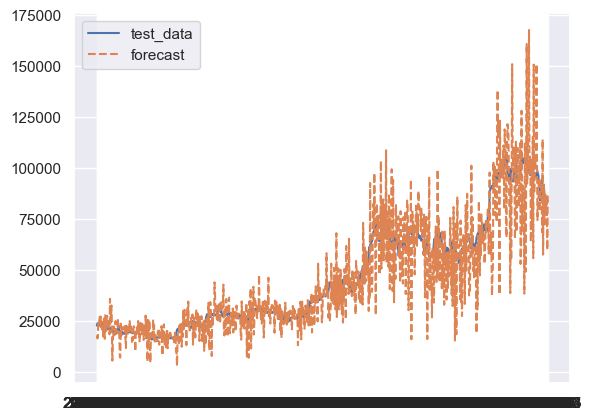

In [67]:
plt.plot(x_test[-len(test_window):],test_label[:,0],label='test_data')
plt.plot(x_test[-len(test_window):],bilstm_forecast,label='forecast',linestyle="--")
plt.legend()
plt.show()

In [68]:
model_3_error=evaluate_preds(test_label,bilstm_forecast)
model_3_error

{'mae': 8449.351, 'mse': 174909970.0, 'rmse': 13225.354, 'mape': 17.593037}

In [134]:
forecast_30 = []
last_window = full_windows[-1] 
current_window = last_window
for _ in range(42):
    pred = model_3.predict(current_window.reshape(1, WINDOW_SIZE, 1), verbose=0)
    forecast_30.append(pred[0][0])
    current_window = np.append(current_window[1:], pred[0][0])
forecast_30 = np.array(forecast_30)


model_3_forecast=pd.DataFrame(
    {
        'datetime':period_date,
        'forecast':forecast_30
    }
)

model_3_forecast.set_index('datetime',inplace=True)


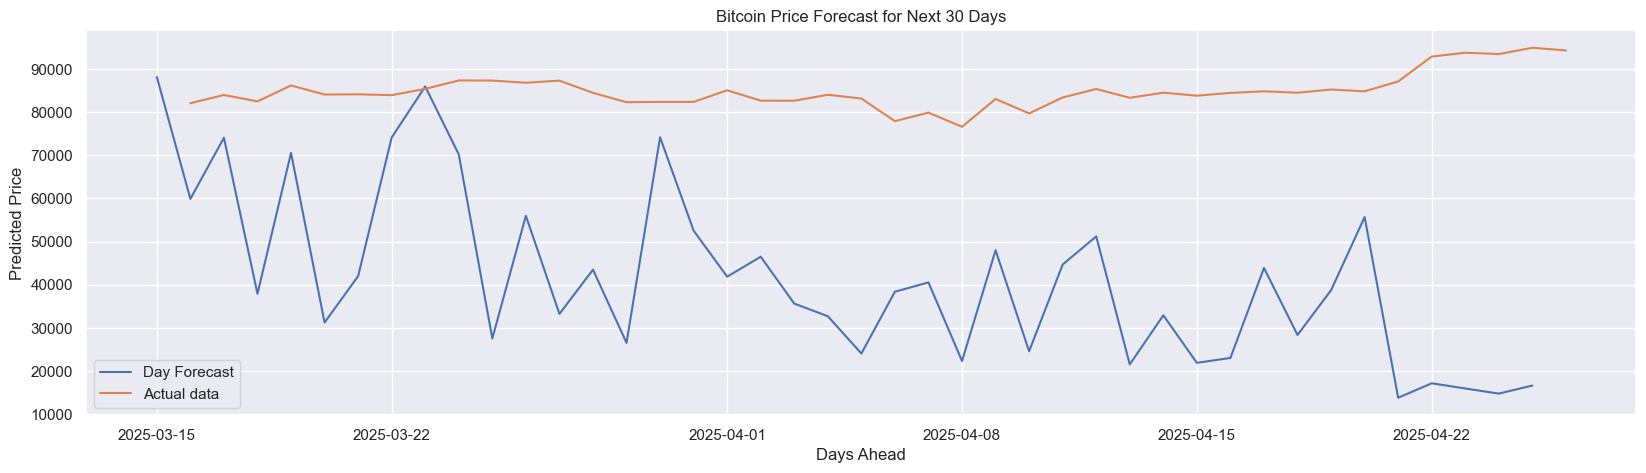

{'mae': 43752.81, 'mse': 2345889300.0, 'rmse': 48434.383, 'mape': 51.103706}

In [137]:
plot_actual_forecast(forecast=model_3_forecast,actualData=actualData)
model_3_forecast_error=evaluate_preds(y_pred=model_3_forecast.values,y_true=actualData.values)
model_3_forecast_error


In [ ]:
##############################################################       ARIMA      ###################################################################

In [ ]:
adf_test(data['Close'])


ADF Statistic: -0.40226673522269596
p-value: 0.9097196252592958
The series is NOT stationary.


In [71]:
diff_df = data.diff().dropna()


In [72]:
adf_test(diff_df['Close'])

ADF Statistic: -9.602150554420273
p-value: 1.9079159596224348e-16
The series is stationary.


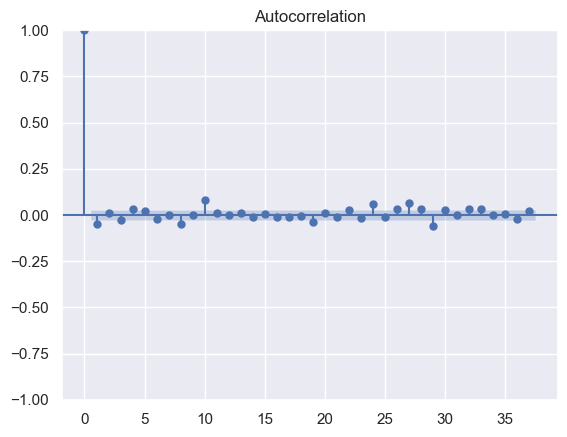

In [73]:
plot_acf(diff_df['Close'])
plt.show()

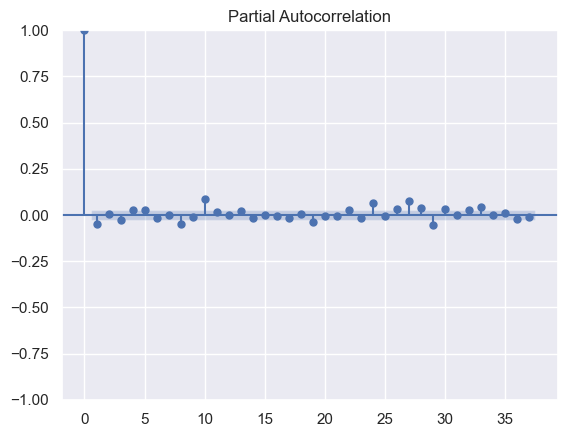

In [74]:
plot_pacf(diff_df['Close'],use_vlines=True)
plt.show()

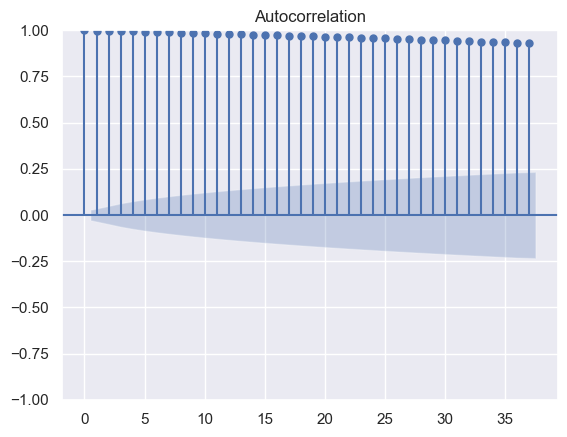

In [76]:
acf=plot_acf(data)

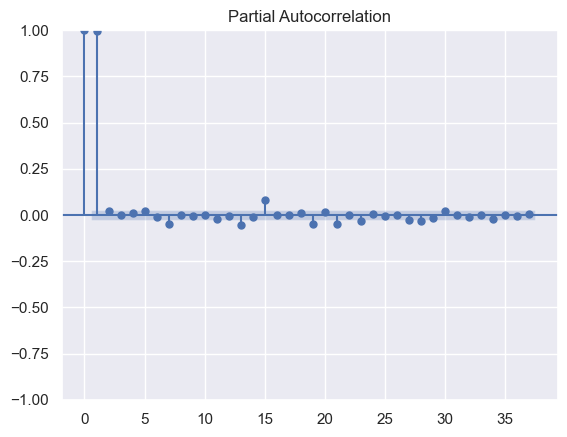

In [77]:
pacf=plot_pacf(data)

In [118]:
actualData=actual_30_days()

In [ ]:
model_4 = ARIMA(data, order=(29,1,30))
model_fit=model_4.fit()


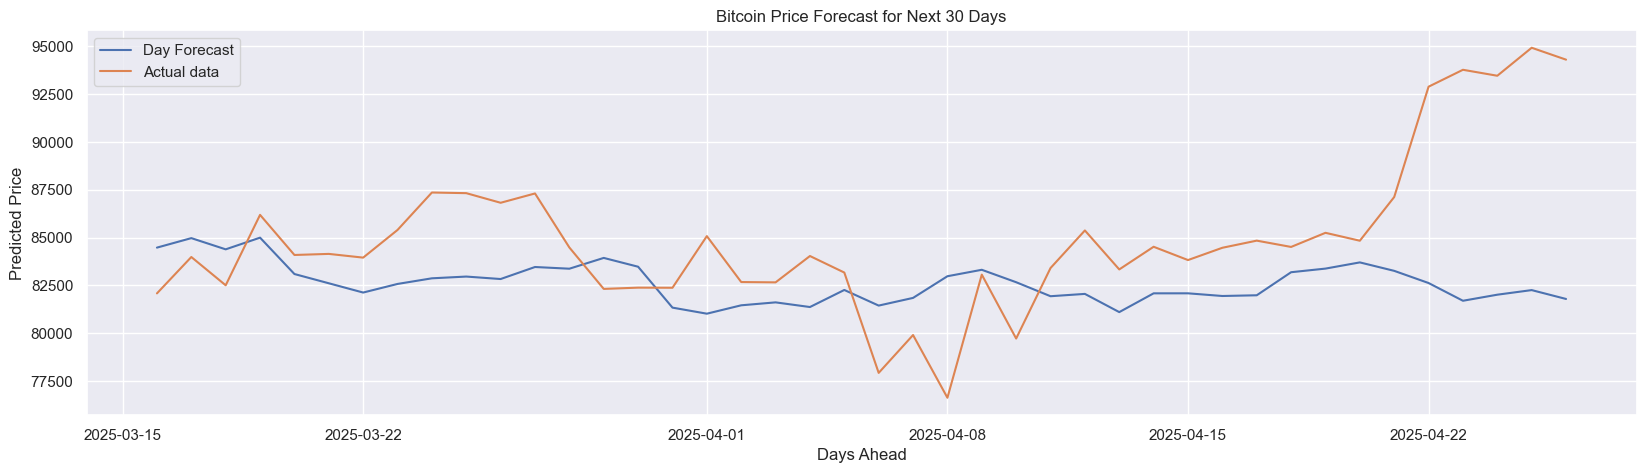

In [128]:
forecast_30_arima=model_fit.forecast(steps=42)
plot_actual_forecast(forecast_30_arima,actualData)

In [129]:
model_4_error=evaluate_preds(y_pred=forecast_30_arima.values,y_true=actualData.values)
model_4_error

{'mae': 3426.1514, 'mse': 22810816.0, 'rmse': 4776.067, 'mape': 3.9119642}

In [95]:
model_4_2= ARIMA(data, order=(15,1,15))
model_fit_2=model_4_2.fit()

c:\Users\HP - Victus\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\HP - Victus\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\HP - Victus\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\HP - Victus\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


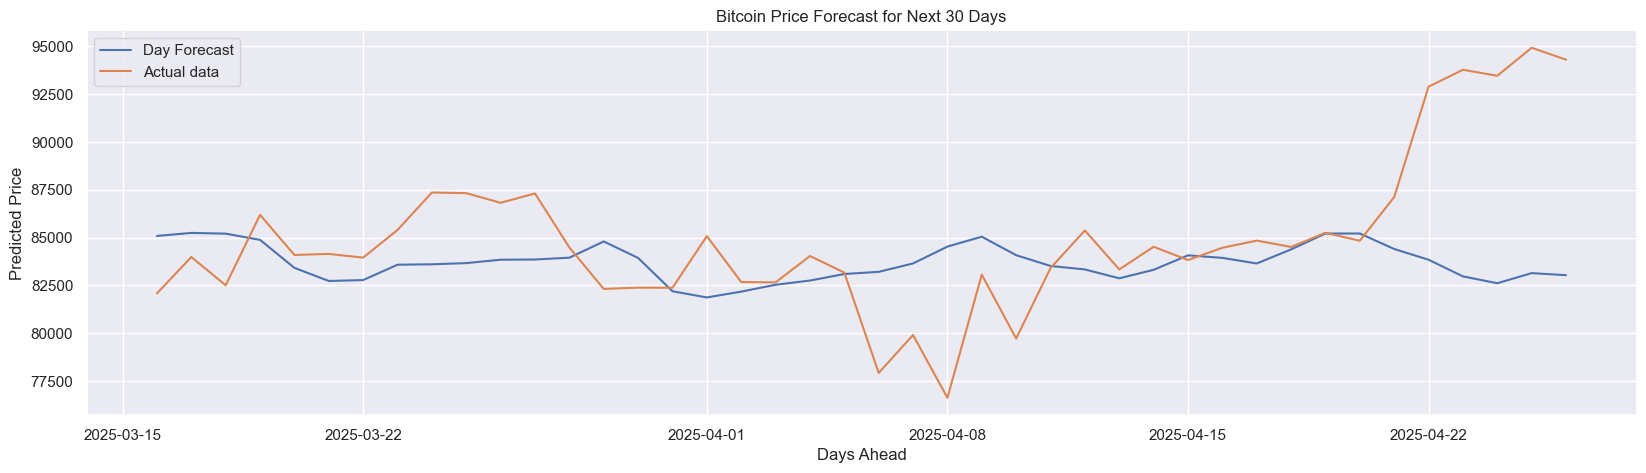

In [124]:
forecast_30_arima=model_fit_2.forecast(steps=42)
plot_actual_forecast(forecast_30_arima,actualData)

In [126]:
model_4_2_error=evaluate_preds(y_pred=forecast_30_arima.values,y_true=actualData.values)
model_4_2_error


{'mae': 2935.0715, 'mse': 19560936.0, 'rmse': 4422.775, 'mape': 3.3633285}

In [121]:
from datetime import datetime

# Start and current date
start_date = datetime(2025, 3, 15)
current_date = datetime.today()

# Calculate the number of days
days_difference = (current_date - start_date).days
days_difference


42

In [92]:
bitcoin_price_today_forecast=model_fit.forecast(steps=days_difference);
print(f'the predicted price of the BTC today {current_date} is = {bitcoin_price_today_forecast[-1]}')

the predicted price of the BTC today 2025-04-26 18:23:07.462303 is = 83031.2273772629


In [ ]:
##############################################################       prophet      ###################################################################

In [ ]:
data_prophet=wrangle("D:\\data science projects\\project 2 unfinished\\btcusd_1-min_data.csv")
data_prophet=data_prophet.reset_index()
data_prophet = data_prophet.rename(columns={"datetime": "ds", "Close": "y"})
data_prophet=data_prophet.drop(columns=['Open','High','Low','Volume'])

In [97]:
#data_prophet['y'] = data_prophet['y'].rolling(30).mean()

In [98]:
data_prophet

,ds,y
0,2012-1-1,4.84
1,2012-1-2,5.00
2,2012-1-3,5.29
3,2012-1-4,5.57
4,2012-1-5,6.42
...,...,...
4818,2025-3-11,78763.00
4819,2025-3-12,83620.00
4820,2025-3-13,83677.00
4821,2025-3-14,83975.00


In [ ]:
# Create and train the model
model_5= Prophet(changepoint_prior_scale=0.7)  # Default is 0.05
model_5.fit(data_prophet)

18:27:47 - cmdstanpy - INFO - Chain [1] start processing
18:27:50 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
future = model_5.make_future_dataframe(periods=30)
forecast = model_5.predict(future)
model_5_forecast=pd.DataFrame(
    {
        'datetime':future[-30:]['ds'],
        'forecast':forecast[-30:]['yhat']
    }
)

model_5_forecast.set_index('datetime',inplace=True)

In [110]:
actualData

Date
2025-03-29    82346.0
2025-03-30    82547.0
2025-03-31    82404.0
2025-04-01    85013.0
2025-04-02    86412.0
2025-04-03    82037.0
2025-04-04    83814.0
2025-04-05    82766.0
2025-04-06    79554.0
2025-04-07    78291.0
2025-04-08    76748.0
2025-04-09    82328.0
2025-04-10    79555.0
2025-04-11    83821.0
2025-04-12    84890.0
2025-04-13    83858.0
2025-04-14    84891.0
2025-04-15    84068.0
2025-04-16    84298.0
2025-04-17    84775.0
2025-04-18    84510.0
2025-04-19    85082.0
2025-04-20    84633.0
2025-04-21    87341.0
2025-04-22    91395.0
2025-04-23    93512.0
2025-04-24    93645.0
2025-04-25    95182.0
2025-04-26    94115.0
Freq: D, Name: Close, dtype: float64

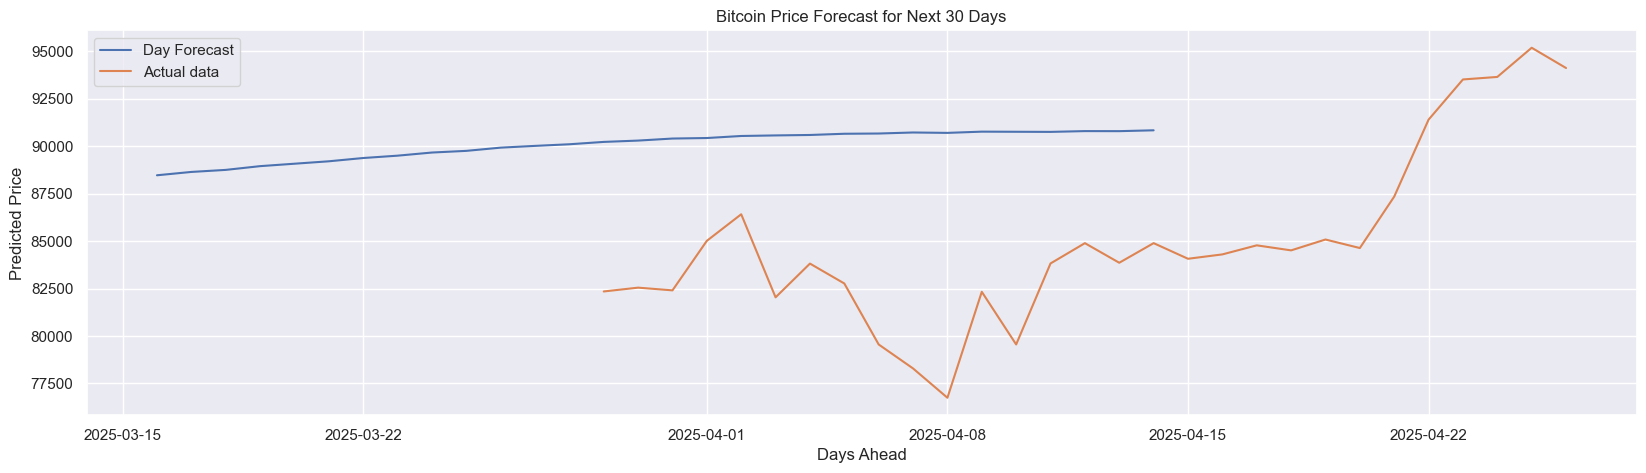

In [109]:
plot_actual_forecast(forecast=model_5_forecast,actualData=actualData)

In [106]:
model_5_error=evaluate_preds(y_pred=forecast[-29:]['yhat'],y_true=actualData.values)
model_5_error

{'mae': 6593.0464, 'mse': 52091092.0, 'rmse': 7217.416, 'mape': 8.012018}

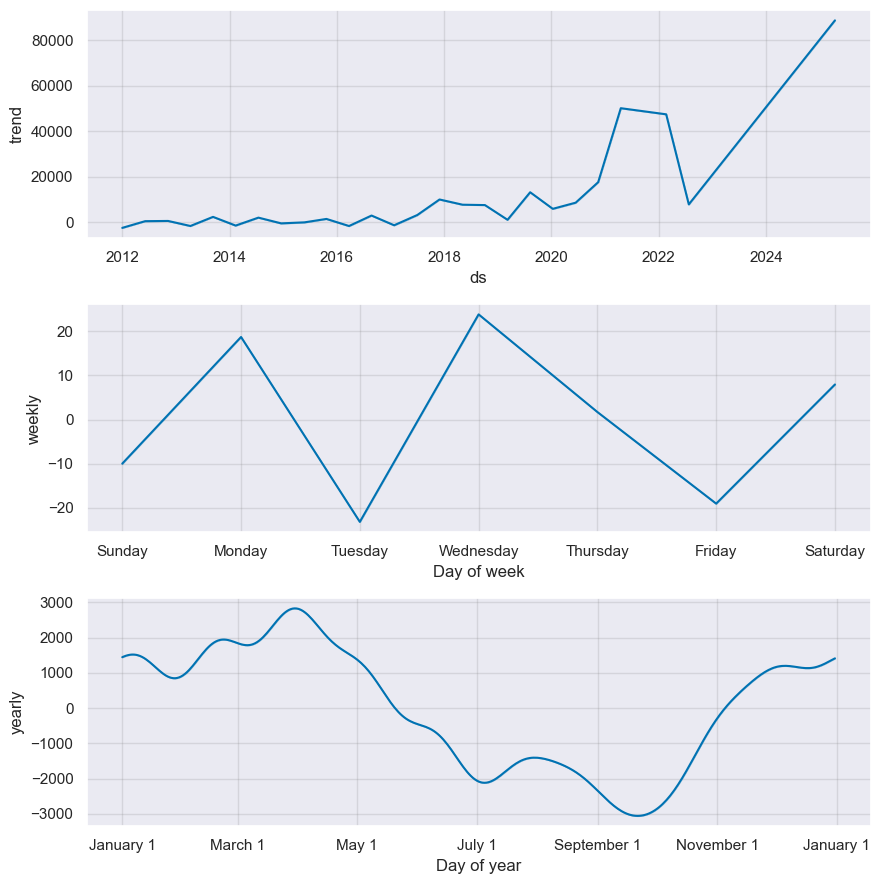

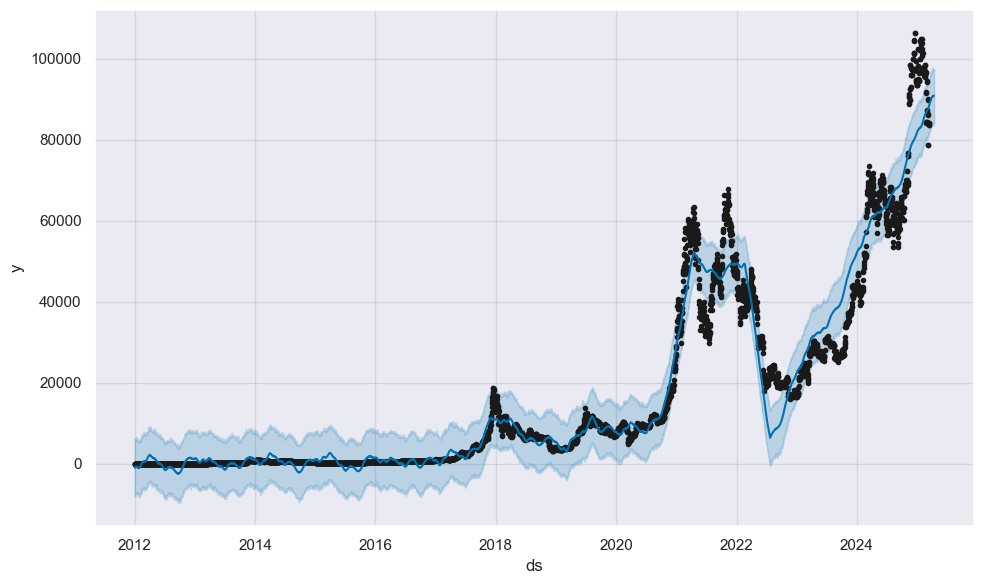

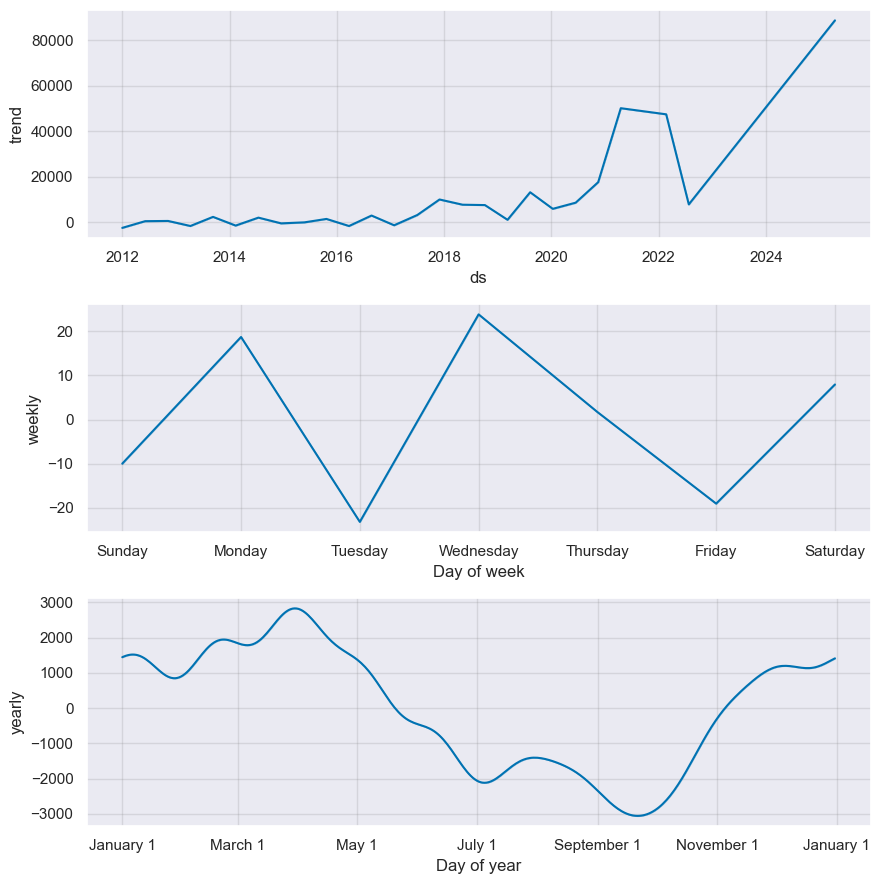

In [107]:
model.plot(forecast)
model.plot_components(forecast)